# Black Box model: 


In [204]:
import pandas as pd
from sklearn.model_selection import train_test_split
import data_processing 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

from sklearn.inspection import PartialDependenceDisplay
import shap
from sklearn.inspection import permutation_importance

## 1. Find most important Features:



### 1.1 pick most correlating to target feature:


Index(['Absolute Magnitude', 'Orbit Uncertainity',
       'Minimum Orbit Intersection', 'Perihelion Distance'],
      dtype='object')


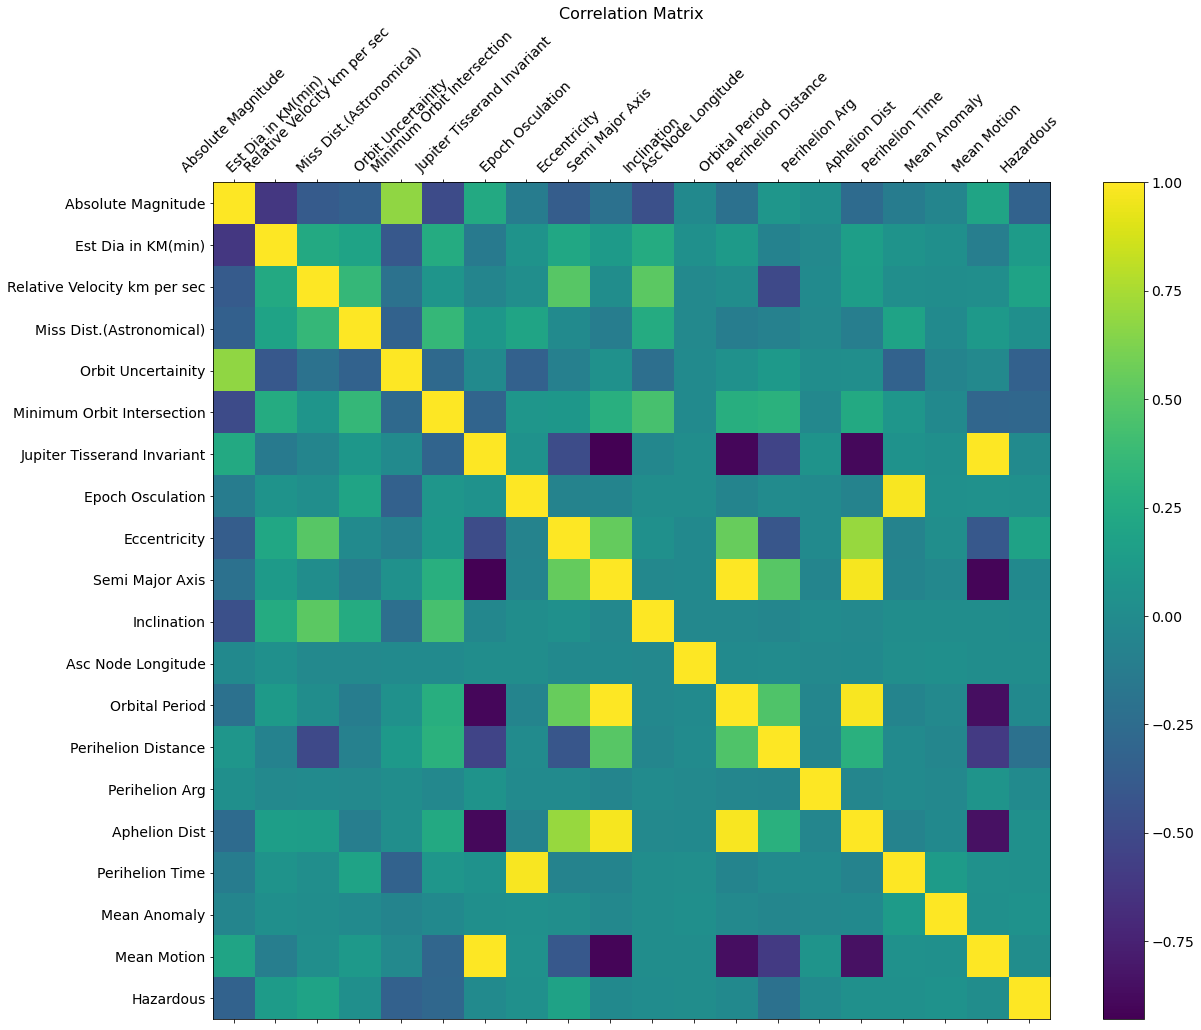

In [164]:
X, y = data_processing.load_nasa()
df = pd.concat([X, y], axis=1)
cor = df.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
cor_target = abs(cor["Hazardous"])
relevant_features = cor_target[cor_target>0.2]
relevant_features.drop(labels=["Hazardous"], inplace=True)
print(relevant_features.index)

X_corr_most = X[relevant_features.index]
#X_corr_most.drop(column=["Hazardous"], inplace=True)

### 1.2 pick by decision tree importance

Text(0, 0.5, 'Feature')

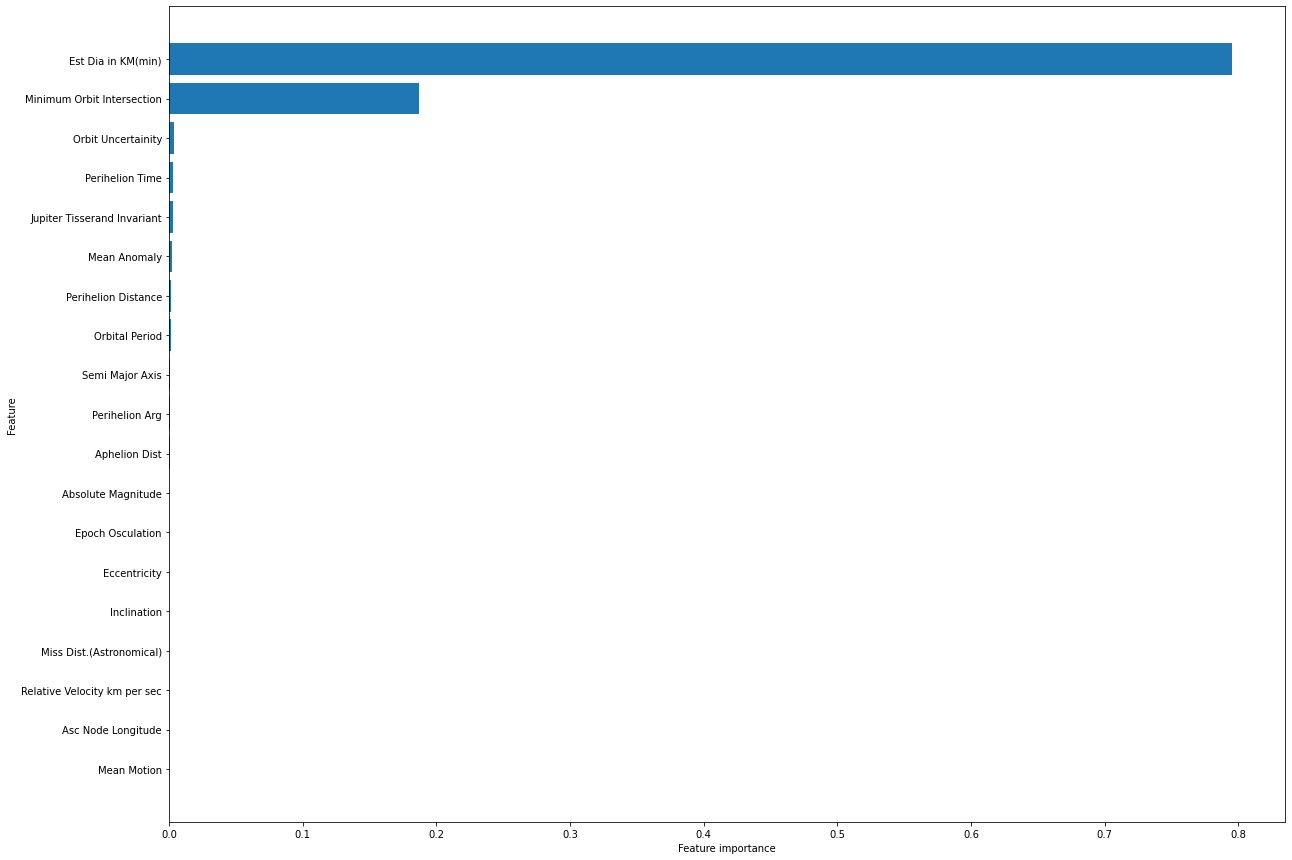

In [91]:
# DECISION TREE
# show most important:

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X, y)
feature_importance = dt.feature_importances_ 
sorted_idx = np.argsort(feature_importance) # Sort index on feature importance
fig = plt.figure(figsize=(20, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])

plt.xlabel("Feature importance") # Add x axis
plt.ylabel("Feature") # Add y axis

In [165]:
# pick k most important features
k = 2
X_most_dt = X[X.columns[np.flip(sorted_idx)][0:k]]
X_most_dt 

,Est Dia in KM(min),Minimum Orbit Intersection
0,0.127220,0.025282
1,0.146068,0.186935
2,0.231502,0.043058
3,0.008801,0.005512
4,0.127220,0.034798
...,...,...
4682,0.044112,0.019777
4683,0.006089,0.006451
4684,0.076658,0.059972
4685,0.116026,0.177510


### 1.3 pick by DT or most corr

In [182]:
# Split into Test and Train
X = X_corr_most

## 2. Add feature with normal distribution

In [186]:
X["random"] = np.random.normal(size=X.shape[0])


,Absolute Magnitude,Orbit Uncertainity,Minimum Orbit Intersection,Perihelion Distance,random
0,21.600,5,0.025282,0.808259,1.809029
1,21.300,3,0.186935,0.718200,-0.272066
2,20.300,0,0.043058,0.950791,-0.767048
3,27.400,6,0.005512,0.983902,-0.837970
4,21.600,1,0.034798,0.967687,-0.562529
...,...,...,...,...,...
4682,23.900,8,0.019777,0.741558,1.390662
4683,28.200,6,0.006451,0.996434,-0.790709
4684,22.700,6,0.059972,0.965760,-1.159213
4685,21.800,5,0.177510,1.185467,-0.125586


## 3. Models:


In [187]:
# split into test and train:

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 3.1 Neural Network: 
It depends which neural network we decide to use. I decided for an MLPRegressor
Use the training data to find the best hyperparameters for the MLP using GridSearchCV. Then train the model and predict using the 'best' model with the best parameters. 


In [188]:

from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np

mlp = MLPClassifier()

#Hyperparameters that we consider:
param_grid = {
    'learning_rate_init': [0.001, 0.01, 0.1, 0.2],
    'alpha': [0.0001, 0.001, 0.05, 0.1],
    'activation': ['relu'],
    'hidden_layer_sizes': [(20,), (50,), (100,)],
    'solver': ['adam', 'sgd' ]
}
best_param_grid = {
    'learning_rate_init': [0.01],
    'alpha': [0.0001],
    'activation': ['relu'],
    'hidden_layer_sizes': [(100,)],
    'solver': [ 'adam' ]
}


grid_search = GridSearchCV(mlp, best_param_grid)
grid_search.fit(x_train, y_train)

nn = grid_search.best_estimator_
nn.fit(x_train, y_train, )

y_pred = nn.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")

/home/robin/anaconda3/envs/uu_courses/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RMSE: 0.26525925685552987
Accuracy: 0.929637526652452
F1: 0.7518796992481203


Using 938 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/938 [00:00<?, ?it/s]

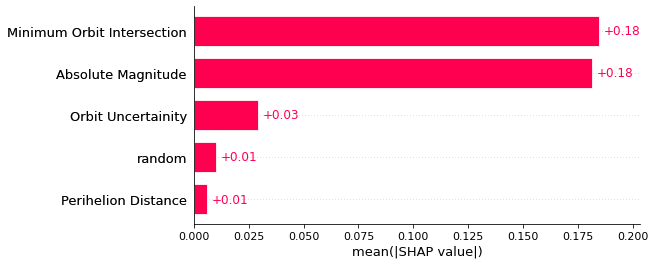

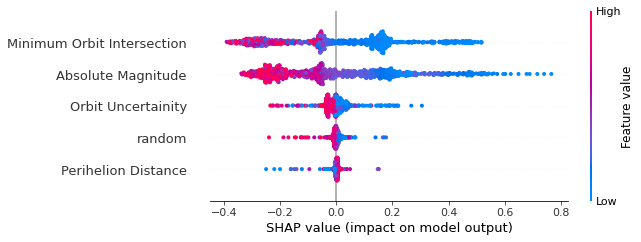

In [189]:
### SHAP
explainer = shap.KernelExplainer(nn.predict,x_test)

shap_values = explainer(x_test)
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)


Text(0.5, 1.0, 'Permutation Importances (test set)')

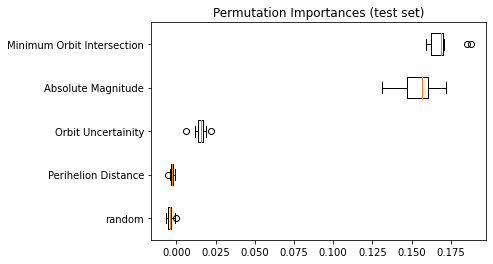

In [192]:
# PFI

pfi = permutation_importance(nn, x_test, y_test, n_repeats=10, random_state=42)
sorted_idx = pfi.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(pfi.importances[sorted_idx].T, vert=False, labels=np.array(X.columns)[sorted_idx])
ax.set_title("Permutation Importances (test set)")


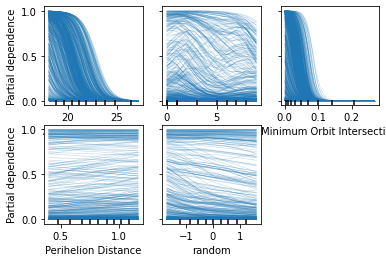

In [203]:
PartialDependenceDisplay.from_estimator(nn, x_test, x_test.columns,

    kind='individual')

### 3.2 EBM (Explainable Boosting Machine)
not part of black box models... just copied from the programming assignment 

In [178]:
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show

ebm = ExplainableBoostingRegressor().fit(x_train, y_train)
### SHAP
y_pred = ebm.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")



RMSE: 0.08297512902109079
Accuracy: 0.9936034115138592
F1: 0.9797297297297297


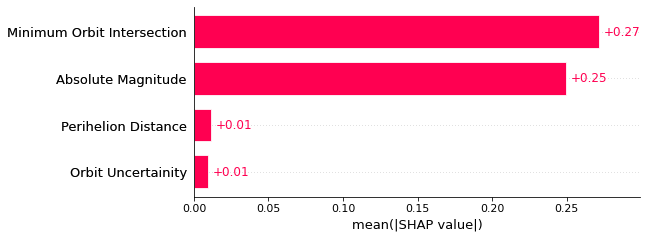

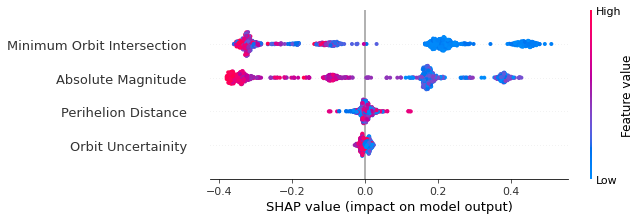

In [179]:
explainer = shap.Explainer(ebm.predict, x_test)

shap_values = explainer(x_test)
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)

Text(0.5, 1.0, 'Permutation Importances (test set)')

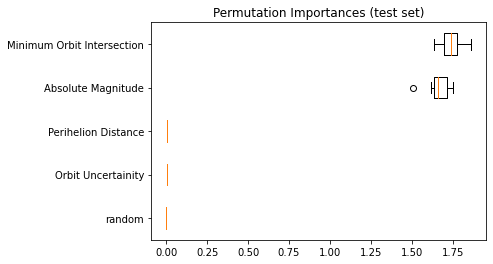

In [193]:
# PFI

pfi = permutation_importance(ebm, x_test, y_test, n_repeats=10, random_state=42)
sorted_idx = pfi.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(pfi.importances[sorted_idx].T, vert=False, labels=np.array(X.columns)[sorted_idx])
ax.set_title("Permutation Importances (test set)")


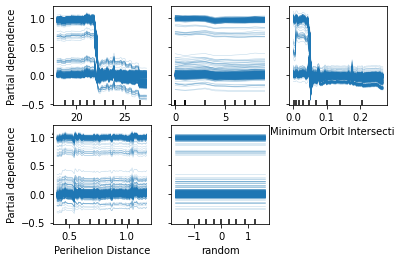

In [205]:
PartialDependenceDisplay.from_estimator(ebm, x_test, x_test.columns,

    kind='individual')